# Four Leaf Clover Classifier

TensorFlow を用いたディープラーニングで四つ葉か否かの分類を行う。<br>
（四つ葉の検出ではない）

----

## 1.事前準備

必要なパッケージをロード

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from clover_images_handler import load_clover

%matplotlib inline

各種設定

In [2]:
image_size = 32  # 画像のサイズ（ピクセル）
n_classes = 1    # 二値での分類問題として扱う
epoch = 100      # 学習回数

データの準備

In [3]:
# 学習用データのロード
clover = load_clover(path='../clover/train',
                     size=image_size,
                     training=True)

x = tf.placeholder(tf.float32, [None, image_size**2])
x_image = tf.reshape(x, [-1, image_size, image_size, 1])

----

## 2.ニューラルネットワークの構築

**1層目**

畳み込み --> プーリング を行う<br>
画像サイズは 32 * 32 --> 16 * 16 * 32

In [4]:
num_filters1 = 32

W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, num_filters1], stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

**2層目**

畳み込み --> プーリング を行う<br>
画像サイズは 16 * 16 * 32 --> 8 * 8 * 64

In [5]:
num_filters2 = 64

W_conv2 = tf.Variable(tf.truncated_normal([5, 5, num_filters1, num_filters2], stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')
b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

**全結合層**

ネットワークのノード数は 8 * 8 * 64  --> 2

In [6]:
num_units1 = 8 * 8 * num_filters2
num_units2 = 2

h_pool2_flat = tf.reshape(h_pool2, [-1, num_units1])
w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

**ドロップアウト層**

In [7]:
keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

**出力層**

ネットワークのノード数は 2  --> 1

このノードの出力値が 0.5 以上なら”四つ葉”と判定する

In [8]:
w0 = tf.Variable(tf.zeros([num_units2, n_classes]))
b0 = tf.Variable(tf.zeros([n_classes]))
p = tf.nn.sigmoid(tf.matmul(hidden2_drop, w0) + b0)

その他予測誤差・予測精度の確認用関数

In [9]:
t = tf.placeholder(tf.float32, [None, n_classes])
loss = -tf.reduce_sum(t * tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

----

## 3.学習開始

※1分程度かかる。

In [10]:
with tf.Session() as sess:

    # 全変数を初期化
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    i = 0
    loss_vals = []

    # 「訓練データの一部を取り出して学習させる」という試行を epoch 回繰り返す
    for _ in range(epoch):
        i += 1
        batch_xs, batch_ts = clover.train.next_batch(16)
        sess.run(train_step, feed_dict={x: batch_xs, t: batch_ts, keep_prob: 0.5})

        # 予測誤差・予測精度の算出
        loss_val, acc_val = sess.run([loss, accuracy],
                                     feed_dict={x: clover.test.images,
                                                t: clover.test.labels,
                                                keep_prob: 1.0})
        loss_vals.append(loss_val)

        # 学習経過の表示
        if i % 10 == 0:
            print('学習回数: {:4d}, 予測誤差: {:.3f}, 予測精度: {:.3f}'.format(i, loss_val, acc_val))
            
    # モデルの保存
    saver.save(sess, '../model/flc')

学習回数:   10, 予測誤差: 8.281, 予測精度: 0.417
学習回数:   20, 予測誤差: 8.125, 予測精度: 0.583
学習回数:   30, 予測誤差: 8.205, 予測精度: 0.583
学習回数:   40, 予測誤差: 8.063, 予測精度: 0.583
学習回数:   50, 予測誤差: 7.667, 予測精度: 0.583
学習回数:   60, 予測誤差: 7.596, 予測精度: 0.583
学習回数:   70, 予測誤差: 7.474, 予測精度: 0.500
学習回数:   80, 予測誤差: 7.435, 予測精度: 0.417
学習回数:   90, 予測誤差: 7.654, 予測精度: 0.583
学習回数:  100, 予測誤差: 7.460, 予測精度: 0.667


----

### （参考）学習結果の可視化

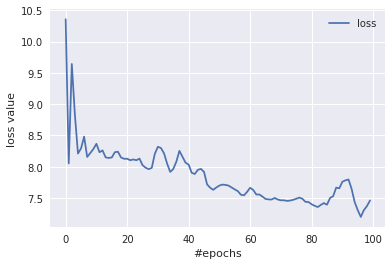

In [11]:
import warnings
warnings.filterwarnings('ignore')

n_epoch = np.arange(0, epoch)
plt.plot(n_epoch, loss_vals, label='loss')
plt.xlabel('#epochs')
plt.ylabel('loss value')
plt.legend(loc='best')

----

## 4.未知データの分類予測

In [12]:
# テスト用データのロード
test_clover = load_clover(path='../clover/prediction')

with tf.Session() as sess:
    # 学習済みモデルのロード
    tf.train.Saver().restore(sess, '../model/flc')
    predictions = sess.run(p, feed_dict={x: test_clover.images, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ../model/flc


### テスト用データに対する判定を表示

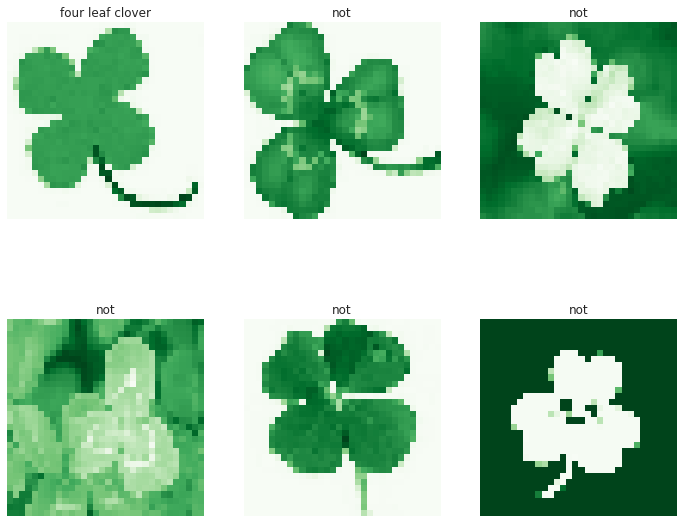

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

for i in range(len(test_clover.images)):
    prediction = predictions[i]
    image = test_clover.images[i]
    label = test_clover.labels[i]
    
    axes[i%2, i%3].set_xticks([])
    axes[i%2, i%3].set_yticks([])
    axes[i%2, i%3].set_title('four leaf clover' if prediction >= 0.5 else 'not')
    axes[i%2, i%3].imshow(image.reshape(image_size, image_size), cmap=plt.cm.Greens_r)

----

#### 【3.学習開始】 のセル以降を再実行（Shift + Enter）させると、毎回違った結果が得られる。